In [15]:
##############

In [16]:
##############Chroma Key

In [17]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
import matplotlib.pyplot as plt
from PIL import Image # Using PIL for resizing consistency with torchvision

def segment_and_replace_background(
    foreground_img_path: str,
    background_img_path: str,
    target_class_id: int = 8, # Default to 8 (cat for COCO dataset model)
    model_input_size: tuple = (520, 520),
    output_path: str = None,
    show_result: bool = True
) -> np.ndarray:
    """
    Performs semantic segmentation on a foreground image, identifies a target object,
    and replaces the background with a new image.

    Args:
        foreground_img_path: Path to the foreground image (containing the object).
        background_img_path: Path to the new background image.
        target_class_id: The class ID of the object to keep (default is 8 for 'cat'
                         in the COCO dataset used by deeplabv3_resnet101).
        model_input_size: The input size (height, width) expected by the model.
        output_path: Optional path to save the resulting image. If None, not saved.
        show_result: If True, displays the resulting image using matplotlib.

    Returns:
        The resulting composite image as an RGB NumPy array.
    """
    # --- 1. Setup Device and Model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Use the recommended 'weights' parameter
    weights = DeepLabV3_ResNet101_Weights.DEFAULT # COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_resnet101(pretrained=True).eval().to(device)
    transforms = weights.transforms() # Get transforms associated with weights

    # --- 2. Load and Preprocess Images ---
    try:
        fore_img = cv2.imread(foreground_img_path)
        back_img = cv2.imread(background_img_path)
        if fore_img is None:
            raise FileNotFoundError(f"Could not load foreground image: {foreground_img_path}")
        if back_img is None:
            raise FileNotFoundError(f"Could not load background image: {background_img_path}")

        # Convert BGR (OpenCV) to RGB
        fore_img_rgb = cv2.cvtColor(fore_img, cv2.COLOR_BGR2RGB)
        back_img_rgb = cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB)

        original_h, original_w = fore_img_rgb.shape[:2]
        print(f"Original foreground image size: ({original_h}, {original_w})")

    except Exception as e:
        print(f"Error loading images: {e}")
        return None

    # --- 3. Prepare Input Tensor for Model ---
    # Use the transforms associated with the loaded weights
    input_tensor = transforms(Image.fromarray(fore_img_rgb)).unsqueeze(0).to(device)

    # --- 4. Perform Segmentation ---
    try:
        with torch.no_grad():
            output = model(input_tensor)["out"][0]
            output_predictions = output.argmax(0).byte().cpu().numpy()
        print(f"Inference mask size (before resize): {output_predictions.shape}")

    except Exception as e:
        print(f"Error during model inference: {e}")
        return None

    # --- 5. Process Mask ---
    # Resize mask to original image size using NEAREST interpolation
    output_predictions_resized = cv2.resize(
        output_predictions, (original_w, original_h), interpolation=cv2.INTER_NEAREST
    )
    print(f"Inference mask size (after resize): {output_predictions_resized.shape}")

    # Create binary mask for the target class
    seg_map = (output_predictions_resized == target_class_id)
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # Make it 3 channels

    # --- 6. Resize Background and Combine ---
    back_img_resized = cv2.resize(back_img_rgb, (original_w, original_h))

    # Combine using the mask
    result_img = np.where(img_mask_color == 255, fore_img_rgb, back_img_resized)
    print("Combining complete.")

    # --- 7. Save and/or Show Result ---
    if output_path:
        try:
            # Convert back to BGR for saving with OpenCV
            result_img_bgr = cv2.cvtColor(result_img.astype(np.uint8), cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, result_img_bgr)
            print(f"Result saved to {output_path}")
        except Exception as e:
            print(f"Error saving image: {e}")

    if show_result:
        plt.figure(figsize=(8, 8))
        plt.imshow(result_img)
        plt.title("Segmented Image with New Background")
        plt.axis('off')
        plt.show()

    return result_img.astype(np.uint8)

# # --- Example Usage ---
# if __name__ == "__main__":
#     cat_image_file = "cat.jpg"
#     desert_image_file = "desert.jpg"
#     output_image_file = "cat_on_desert.jpg"

#     # Make sure cat.jpg and desert.jpg are in the same directory
#     # or provide the full paths.
#     try:
#         # Class ID 8 corresponds to 'cat' in the COCO dataset
#         composite_image = segment_and_replace_background(
#             cat_image_file,
#             desert_image_file,
#             target_class_id=8,
#             output_path=output_image_file,
#             show_result=True
#         )

#         if composite_image is not None:
#              print("Function executed successfully.")
#         else:
#              print("Function execution failed.")

#     except FileNotFoundError as e:
#          print(f"Error: {e}. Make sure the image files exist.")
#     except Exception as e:
#          print(f"An unexpected error occurred: {e}")

Using device: cpu
Original foreground image size: (1341, 2048)
Inference mask size (before resize): (520, 794)
Inference mask size (after resize): (1341, 2048)
Combining complete.


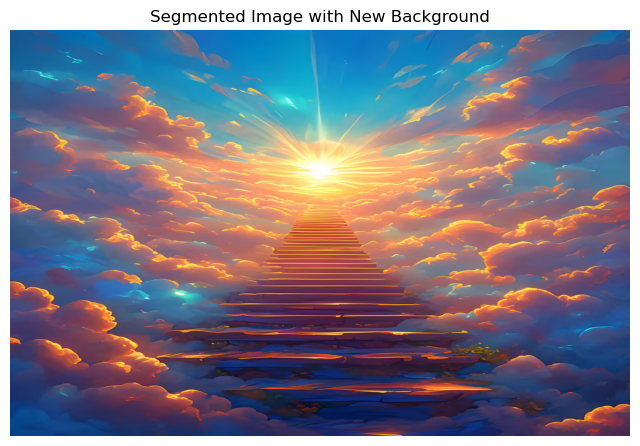

array([[[ 22,  87, 143],
        [ 22,  87, 143],
        [ 22,  87, 143],
        ...,
        [ 35,  87, 144],
        [ 36,  87, 144],
        [ 36,  87, 144]],

       [[ 22,  87, 143],
        [ 22,  87, 143],
        [ 22,  87, 143],
        ...,
        [ 35,  87, 144],
        [ 35,  87, 144],
        [ 35,  87, 144]],

       [[ 22,  87, 143],
        [ 22,  87, 143],
        [ 22,  87, 143],
        ...,
        [ 34,  87, 144],
        [ 35,  87, 144],
        [ 35,  87, 144]],

       ...,

       [[  4,  63, 131],
        [  4,  63, 131],
        [  4,  63, 131],
        ...,
        [ 68,  42,  79],
        [ 68,  42,  79],
        [ 68,  42,  79]],

       [[  4,  63, 131],
        [  4,  63, 131],
        [  4,  63, 131],
        ...,
        [ 68,  42,  79],
        [ 68,  42,  79],
        [ 68,  42,  79]],

       [[  4,  63, 131],
        [  4,  63, 131],
        [  4,  63, 131],
        ...,
        [ 68,  42,  79],
        [ 68,  42,  79],
        [ 68,  42,  79]]

In [18]:
# segment_and_replace_background("cat.jpg", "desert.jpg", target_class_id=8, output_path="cat_on_desert.jpg", show_result=True)



segment_and_replace_background("angel.jpeg", "heaven4.jpg")
